# Imports

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm

from xml.etree import ElementTree as ET
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Normalize

OPENSLIDE_PATH = r"D:\DataManage\openslide-win64-20231011\bin"
if hasattr(os, "add_dll_directory"):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide
from openslide.deepzoom import DeepZoomGenerator

# from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from filter_whites_multiscale import filter_whites
from matplotlib.patches import Rectangle

Windows
Added D:\DataManage\openslide-win64-20231011\bin to the DLL directories


# Visualization

In [2]:
# path_summary = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\p24_summary_uq.csv")
path_summary = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\mdn_summary_uq.csv")

In [3]:
summary = pd.read_csv(path_summary)
summary.path_svs = summary.path_svs.apply(Path)

In [4]:
row = summary.iloc[np.random.randint(0, len(summary))]

In [5]:
tiles_coord, coord_thumb, final_mask, img = filter_whites(row.path_svs, tile_size=224)

100%|██████████| 11036/11036 [00:00<00:00, 89359.38it/s]


  0%|          | 0/6589 [00:00<?, ?it/s]

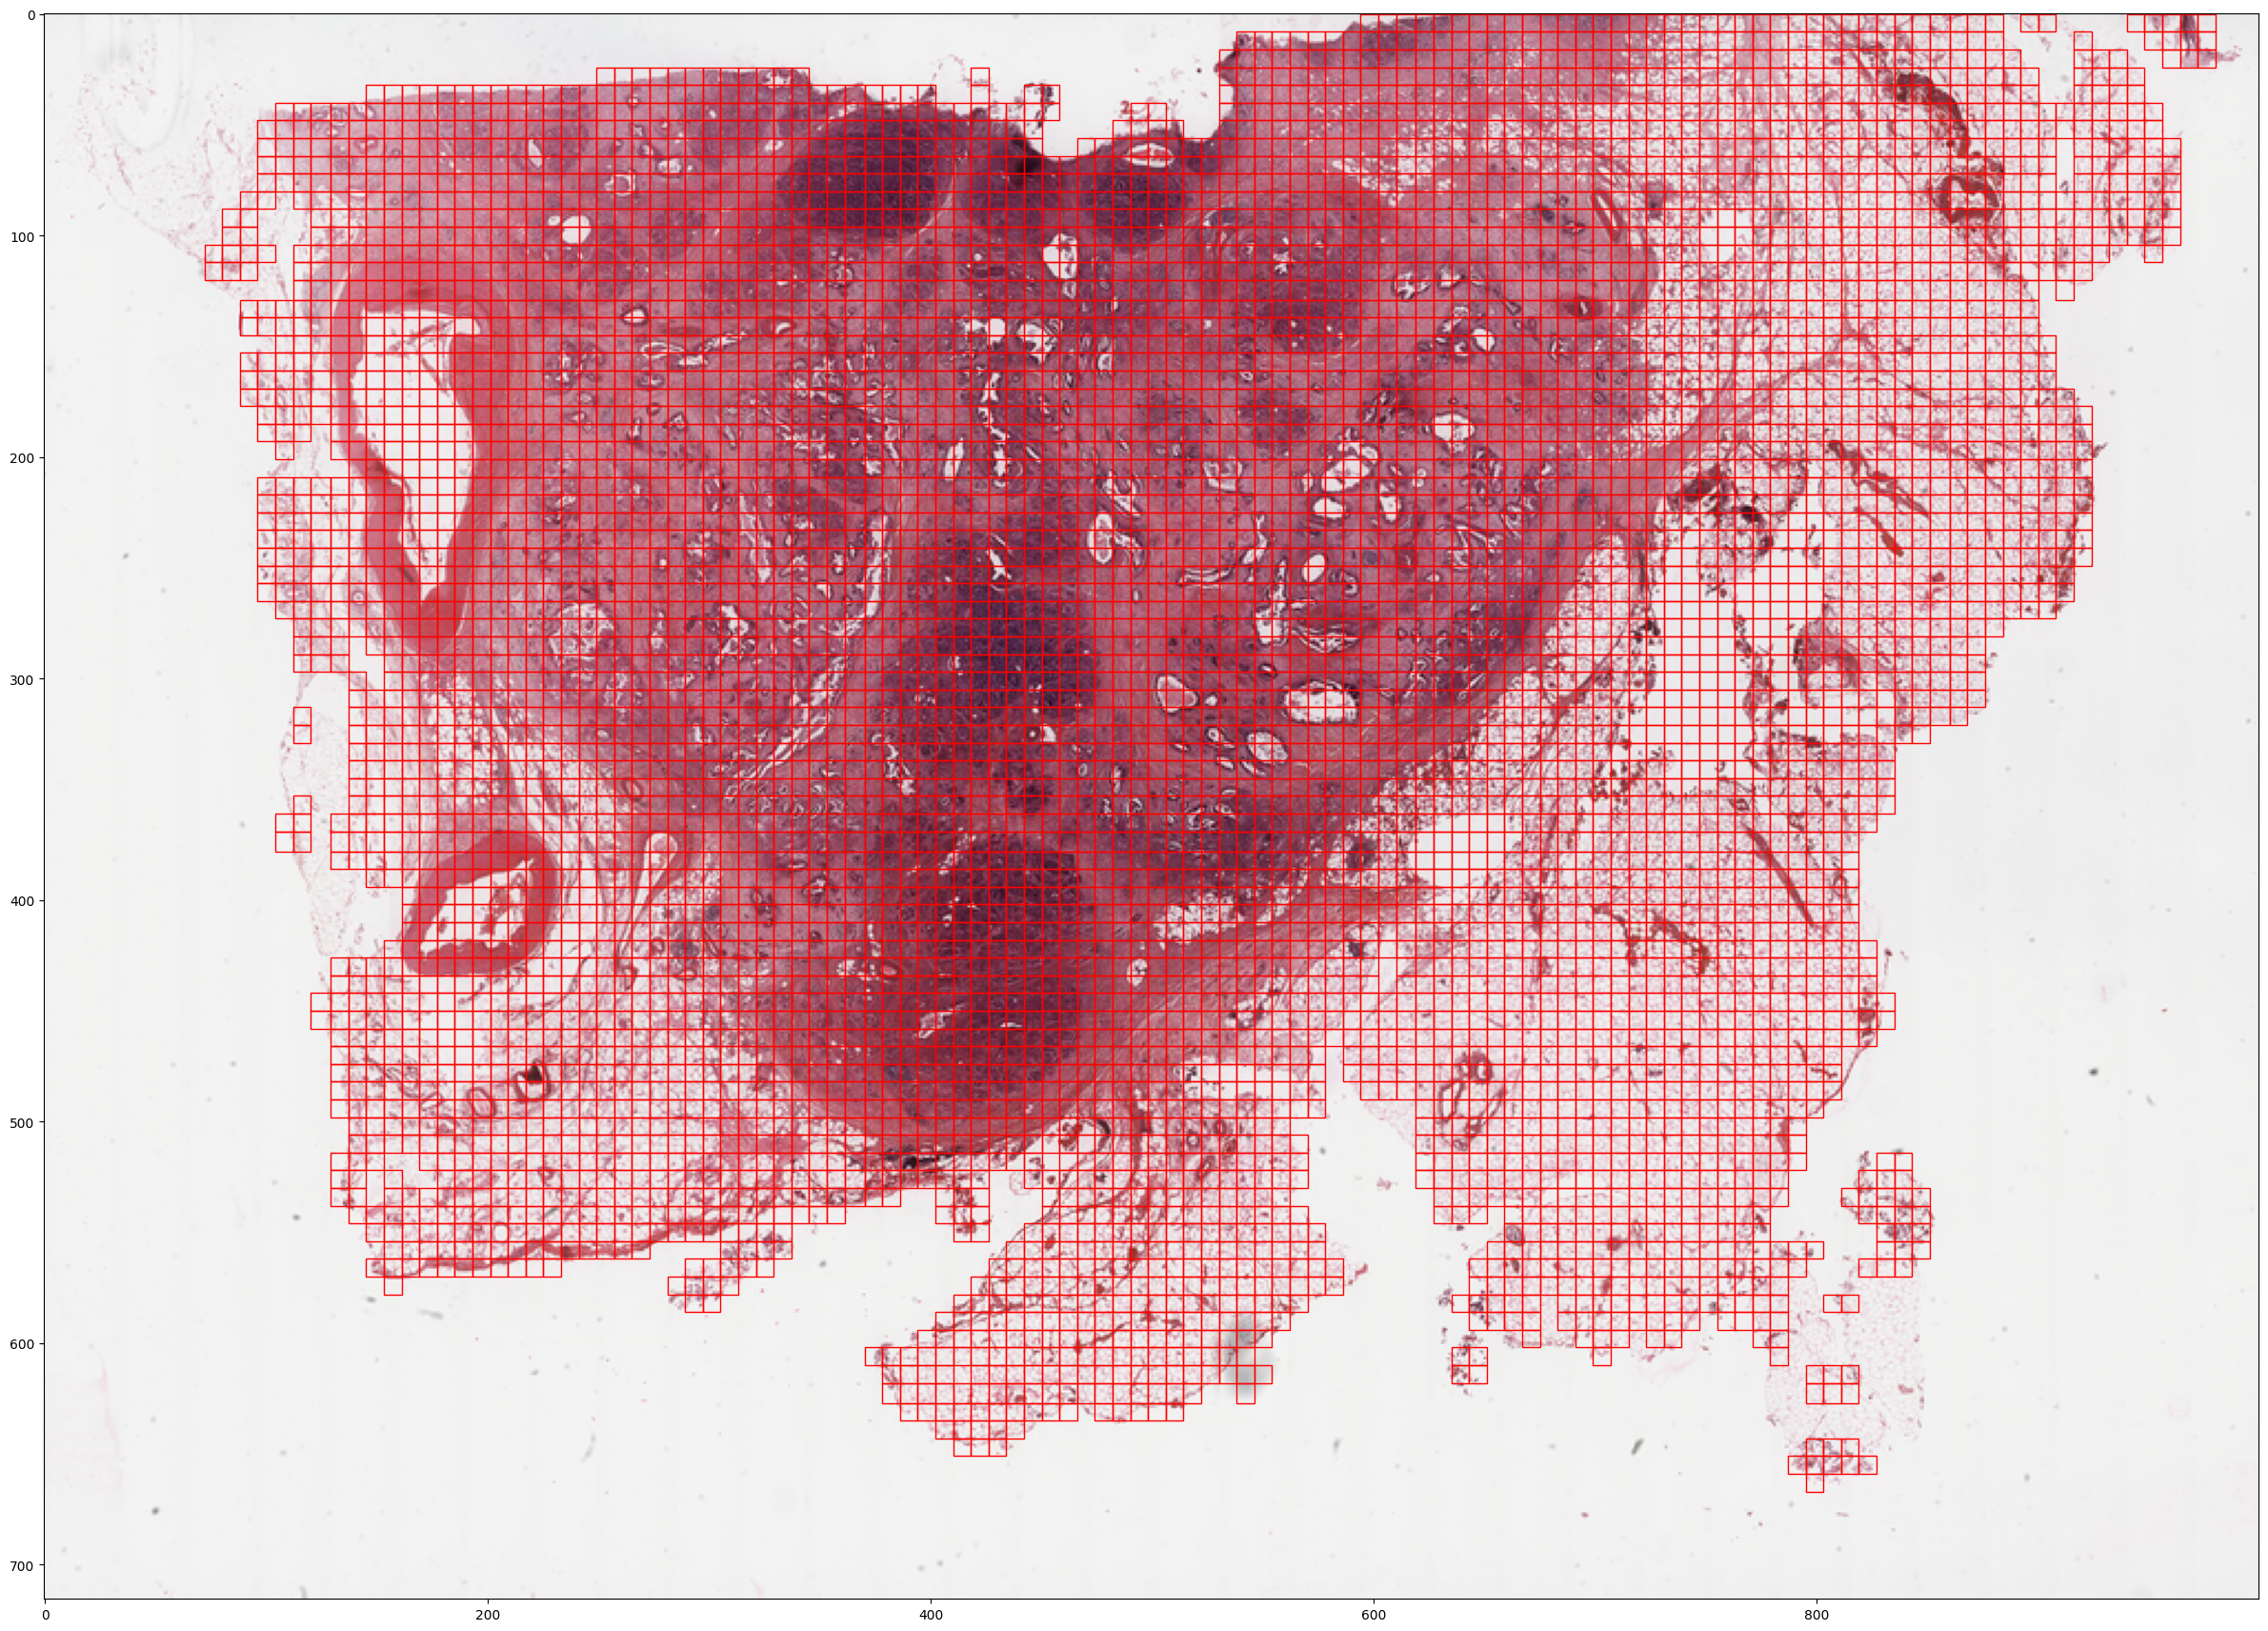

In [6]:
fig, ax = plt.subplots(figsize=(30, 30))
# ax.imshow(final_mask, cmap="gray", alpha=0.5)
ax.imshow(img)
ax = plt.gca()
for k, point in enumerate(tqdm(coord_thumb)):
    height = point[2, 1] - point[0, 1]
    width = point[1, 0] - point[0, 0]
    rect = Rectangle(point[0], width, height, linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)

plt.show()

# Extract statistics

We need to normalize the data for feature extraction. Unfortunately, the author of the model did not provide the code for the feature extraction nor the values of the normalization parameters. We will have to extract these parameters from the training data.

In [7]:
class TilesDataset(Dataset):
    def __init__(self, slide: openslide.OpenSlide, tiles_coords: np.ndarray) -> None:
        self.slide = slide
        self.tiles_coords = tiles_coords
        self.dz = DeepZoomGenerator(slide, tile_size=224, overlap=0)

        file_extension = Path(self.slide._filename).suffix
        if file_extension == ".svs":
            self.zoom_level = int(self.slide.properties["openslide.objective-power"])
        elif file_extension == ".qptiff":
            r = (
                ET.fromstring(slide.properties["openslide.comment"])
                .find("ScanProfile")
                .find("root")
                .find("ScanResolution")
            )
            self.zoom_level = float(r.find("Magnification").text)
        elif file_extension == ".ndpi":
            self.zoom_level = int(self.slide.properties["openslide.objective-power"])
        else:
            raise ValueError(f"File extension {file_extension} not supported")

        # We want the second highest level so as to have 112 microns tiles / 0.5 microns per pixel
        if self.zoom_level == 20:
            self.level = self.dz.level_count - 1
        elif self.zoom_level == 40:
            self.level = self.dz.level_count - 2
            self.zoom_level = 20
        else:
            raise ValueError(f"Objective power {self.zoom_level}x not supported")

        assert np.all(
            self.tiles_coords[:, 0] == self.level
        ), "The resolution of the tiles is not the same as the resolution of the slide."
        self.z = self.level

    def __getitem__(self, item: int):
        tile_coords = self.tiles_coords[item, 2:4].astype(int)

        try:
            im = self.dz.get_tile(level=self.level, address=tile_coords)
        except ValueError:
            print(f"ValueError: impossible to open tile {tile_coords} from {self.slide}")
            raise ValueError

        im = ToTensor()(im)

        if im.shape != torch.Size([3, 224, 224]):
            print(f"Image shape is {im.shape} for tile {tile_coords}. Padding...")
        #     # PAD the image in white to reach 224x224
        #     im = torch.nn.functional.pad(im, (0, 224 - im.shape[2], 0, 224 - im.shape[1]), value=1)

        return im

    def __len__(self) -> int:
        return len(self.tiles_coords)

In [8]:
path_coord = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\coordinates_mdn_512")
path_summary = Path(r"C:\Users\inserm\Documents\histo_sign\dataset\mdn_summary_uq.csv")
summary = pd.read_csv(path_summary)
summary.path_svs = summary.path_svs.apply(Path)
summary.reset_index(drop=True, inplace=True)
unique_scan = summary.drop_duplicates(subset="path_svs")

In [20]:
row = summary.iloc[np.random.randint(0, len(summary))]
slide = openslide.OpenSlide(row.path_svs)
print("Resolution :", float(slide.properties["openslide.mpp-x"]))

Resolution : 0.4959


In [9]:
mean_list, std_list = [], []
pbar = tqdm(
    unique_scan.iterrows(), total=len(unique_scan), desc="Computing mean and std", position=1, leave=True
)
for idx, row in pbar:
    pbar.set_description(f"Computing mean and std for {row.ID_scan.ljust(20)}")
    slide = openslide.OpenSlide(row.path_svs)
    tiles_coord = np.load(path_coord / row.sample_ID / "tiles_coord.npy")

    dataset = TilesDataset(slide=slide, tiles_coords=tiles_coord)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=512,
        shuffle=False,
        num_workers=0,
        prefetch_factor=None,
        pin_memory=True,
    )

    mean_list_slide, std_list_slide = [], []
    # for images in tqdm(dataloader, total=len(dataloader), desc=f"{row.sample_ID}", leave=True, position=0):
    for images in dataloader:
        mean_list_slide.append(images.mean(dim=[0, 2, 3]))
        std_list_slide.append(images.std(dim=[0, 2, 3]))

    mean_list += mean_list_slide
    std_list += std_list_slide

Computing mean and std:   0%|          | 0/238 [00:00<?, ?it/s]

In [11]:
print(torch.stack(mean_list).mean(dim=0), torch.stack(std_list).mean(dim=0))

tensor([0.8734, 0.7730, 0.7974]) tensor([0.0846, 0.1234, 0.1127])
